In [ ]:
pip install pytorch-forecasting torch pandas numpy matplotlib optuna pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.1 MB/s eta 0:00:00


### This post uses all tickers into group and included in TFT model

In [ ]:
import os
import sys
import copy

import pickle
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import lightning.pytorch as pl
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import torch
from torch.utils.data import DataLoader # Import DataLoader from torch.utils.data


from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss

In [ ]:
from google.colab import drive

# Try unmounting first if it's already mounted
try:
  drive.flush_and_unmount()
  print('Drive unmounted')
except ValueError:
  pass

drive.mount('/content/drive',force_remount=True)

base_path = '/content/drive/My Drive/Able_DahamKim/'
data_path = '/content/drive/My Drive/Able_DahamKim/data/'
input_path = '/content/drive/My Drive/Able_DahamKim/data/input/'
output_path = '/content/drive/My Drive/Able_DahamKim/data/output/'

print("original directory is : ", os.getcwd())
os.chdir(base_path)
print("directory changed to : ", os.getcwd())

Mounted at /content/drive
original directory is :  /content
directory changed to :  /content/drive/My Drive/Able_DahamKim


In [ ]:
from data_single import data_prep

tickers = ["AAPL", "MSFT", "JNJ", "UNH", "KO", "HD", "UNP", "BA", "PG", "WMT", "XOM", "CVX", "AEP", "DUK", "AMT", "SPG"]
term = "DGS3MO" # three month treasury rate for risk_free rate
corr_window = 10 # rolling window for correlation calculation

version_number = 1  # or any other version number you want to specify


# create validation set (predict=True) which means to predict the last max_prediction_length points in time
encoder_length = 365
predict_length = 30
batch_size = 32  # set this between 32 to 128

plot_path = output_path + "plots/"
os.makedirs(plot_path, exist_ok=True)

numeric_path = output_path + "numeric/"
os.makedirs(numeric_path, exist_ok=True)

interprete_path = output_path + "interprete/"
os.makedirs(interprete_path, exist_ok=True)


In [ ]:
_start_date = "2016-07-01"
_end_date = "2024-07-01"

In [ ]:
def build_start_end_date(start_date, end_date, encoder_length, predict_length):
    # Generate the monthly date range from start to end date
    date_range = pd.date_range(start=start_date, end=end_date, freq='MS')

    # Create DataFrame with first and last days of each month
    date_info = pd.DataFrame({
        # "train_start": date_range - pd.Timedelta(days=encoder_length),
        "train_start": date_range - pd.Timedelta(days=365*3),
        "train_end": date_range,
        "predict_start": date_range + pd.Timedelta(days=1),
        "predict_end": date_range + pd.Timedelta(days=30*1)
    })

    for pred_start in date_info['predict_start']:
      temp_dir = numeric_path + pred_start.strftime("%Y-%m-%d") + "/"
      os.makedirs(temp_dir, exist_ok=True)

      temp_dir = plot_path + pred_start.strftime("%Y-%m-%d") + "/"
      os.makedirs(temp_dir, exist_ok=True)

    #   temp_dir = interprete_path + pred_start.strftime("%Y-%m-%d") + "/"
    #   os.makedirs(temp_dir, exist_ok=True)

      temp_dir = base_path + f"lightning_logs_adj_return/3_years/version_{version_number}/" + pred_start.strftime("%Y-%m-%d") + "/"
      os.makedirs(temp_dir, exist_ok=True)

    return date_info

# Use the function
# time_bounds = build_start_end_date(_start_date, _end_date, encoder_length=encoder_length, predict_length=predict_length )
time_bounds = build_start_end_date(_start_date, _end_date, encoder_length=365*3, predict_length=30 )

In [ ]:
def build_input(base_path, data_path, tickers, term, start, end, corr_window):

    df_cpi = pd.read_csv(data_path + "cpi.csv", index_col=0)
    df_cpi.index = pd.to_datetime(df_cpi.index)
    df_cpi = df_cpi.loc[start:end]

    df_unemp = pd.read_csv(data_path + 'unemploy.csv', index_col = 0)
    df_unemp.index = pd.to_datetime(df_unemp.index)
    df_unemp = df_unemp.loc[start:end]

    combined_df = pd.concat([df_cpi, df_unemp], axis=0)
    combined_df['macro_event'] = combined_df.notna().any(axis=1)
    macro_df = combined_df[['macro_event']]
    macro_df['macro_event'] = macro_df['macro_event'].apply(lambda x : 'macro' if x == True else 'normal')
    macro_df['macro_event'] = macro_df['macro_event']

    is_first = True
    for ticker in tickers:
        data = data_prep(base_path=base_path, ticker=ticker, term=term, pred_delta=0, corr_window=corr_window)
        df_input = data.df_input.loc[start:end]
        print(ticker, df_input.shape)

        df = df_input.join(macro_df, how="left")
        df['macro_event'] = df['macro_event'].fillna('normal')
        df['macro_event'] = df['macro_event'].astype("category")
        df.rename(columns={'macro_event': 'event calendar'}, inplace=True)

        df.reset_index(drop=False, inplace=True)
        df['Date'] = pd.to_datetime(df['Date'])
        df['time_idx'] = (df['Date'] - df['Date'].min()).dt.days

        df['ticker'] = ticker
        df['sector'] = 'misc'
        if ticker in ['AAPL','MSFT']:
          df['sector'] = 'information technology'
        elif ticker in ['JNJ','UNH']:
          df['sector'] = 'health care'
        elif ticker in ['WMT','HD']:
          df['sector'] = 'consumer discretionary'
        elif ticker in ['UNP', 'BA']:
          df['sector'] = 'industrials'
        elif ticker in ['XOM', 'CVX']:
          df['sector'] = 'energy'
        elif ticker in ['PG','KO']:
          df['sector'] = 'consumer staples'
        elif ticker in ['AEP', 'DUK']:
          df['sector'] = 'utilities'
        elif ticker in ['AMT', 'SPG']:
          df['sector'] = 'real estate'

        if is_first:
            df_all = df.copy()
            is_first = False
        else:
            df_all = pd.concat([df_all,df])
            df_all.reset_index(drop=True, inplace=True)
    return df_all


In [ ]:
def create_dataset(data, encoder_length, max_prediction_length):

    ts_dataset = TimeSeriesDataSet(
        data[lambda x: x.time_idx <= data['time_idx'].max() - max_prediction_length],
        time_idx="time_idx",
        target="Adj Return Delta 1",
        group_ids=["ticker"],
        min_encoder_length=encoder_length // 2,
        max_encoder_length=encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=["ticker", "sector"],
        time_varying_known_categoricals=["event calendar"],
        time_varying_known_reals=[
            "time_idx", "Riskfree",
            'Riskfree_change',
            "CDS Premium",
            "CDS Premium Change Delta 1",
            "Levered_FCF_1_year",
            "Perpetuity_Growth"
        ],
        time_varying_unknown_reals=[
            "Adj Return Delta 1",
        ],
        # target_normalizer=GroupNormalizer(groups=["group"], transformation="softplus"),
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
        allow_missing_timesteps=True,
    )
    return ts_dataset


97 / 97 2021-07-02 00:00:00 2024-07-01 00:00:00 2024-07-31 00:00:00
AAPL (774, 8)
MSFT (774, 8)
JNJ (774, 8)
UNH (774, 8)
KO (774, 8)
HD (774, 8)
UNP (774, 8)
BA (774, 8)
PG (774, 8)
WMT (774, 8)
XOM (774, 8)
CVX (774, 8)
AEP (774, 8)
DUK (774, 8)
AMT (774, 8)
SPG (774, 8)
encoder_length is  753  and predict_length is  21


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Seed set to 100
INFO:lightning.fabric.utilities.seed:Seed set to 100
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_D

Baseline MAE: 0.013
Number of parameters in network: 558.7k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: LR finder stopped early after 90 steps due to diverging loss.
INFO:lightning.pytorch.tuner.lr_finder:LR finder stopped early after 90 steps due to diverging loss.
INFO: Learning rate set to 0.000331131121482591
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.000331131121482591
INFO: Restoring states from the checkpoint path at /content/drive/My Drive/Able_DahamKim/.lr_find_412a5524-0c51-4b04-a9f0-bff00412589b.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/My Drive/Able_DahamKim/.lr_find_412a5524-0c51-4b04-a9f0-bff00412589b.ckpt
INFO: Restored all states from the checkpoint at /content/drive/My Drive/Able_DahamKim/.lr_find_412a5524-0c51-4b04-a9f0-bff00412589b.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/drive/My Drive/Able_DahamKim/.lr_find_412a5524-0c51-4b04-a9f0-bff00412589b.ckpt


suggested learning rate: 0.000331131121482591


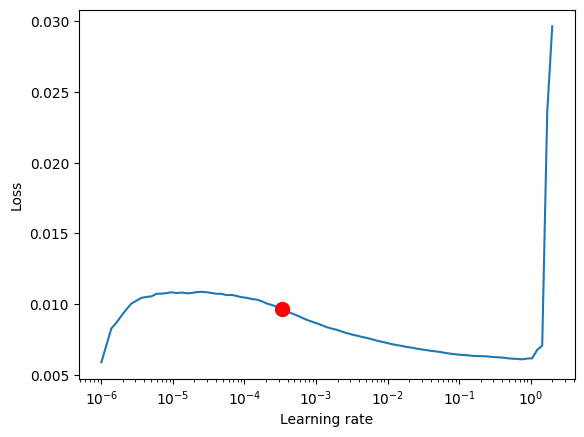

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 170    | train
3  | prescalers       

Number of parameters in network: 558.7k


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Best model was saved at epoch 4763.ckpt
Best model was saved at location lightning_logs/lightning_logs/version_0/checkpoints/epoch=10-step=4763.ckpt


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_V

Baseline MAE: 0.013
2024-07-02 00:00:00 period prediction MAE
0.012512654066085815
tensor([0.0133, 0.0116, 0.0168, 0.0155, 0.0130, 0.0089, 0.0162, 0.0125, 0.0102,
        0.0132, 0.0133, 0.0100, 0.0158, 0.0116, 0.0051, 0.0134],
       device='cuda:0')
AAPL daily stock return prediction for 2024-07-02 00:00:00 next 21 days


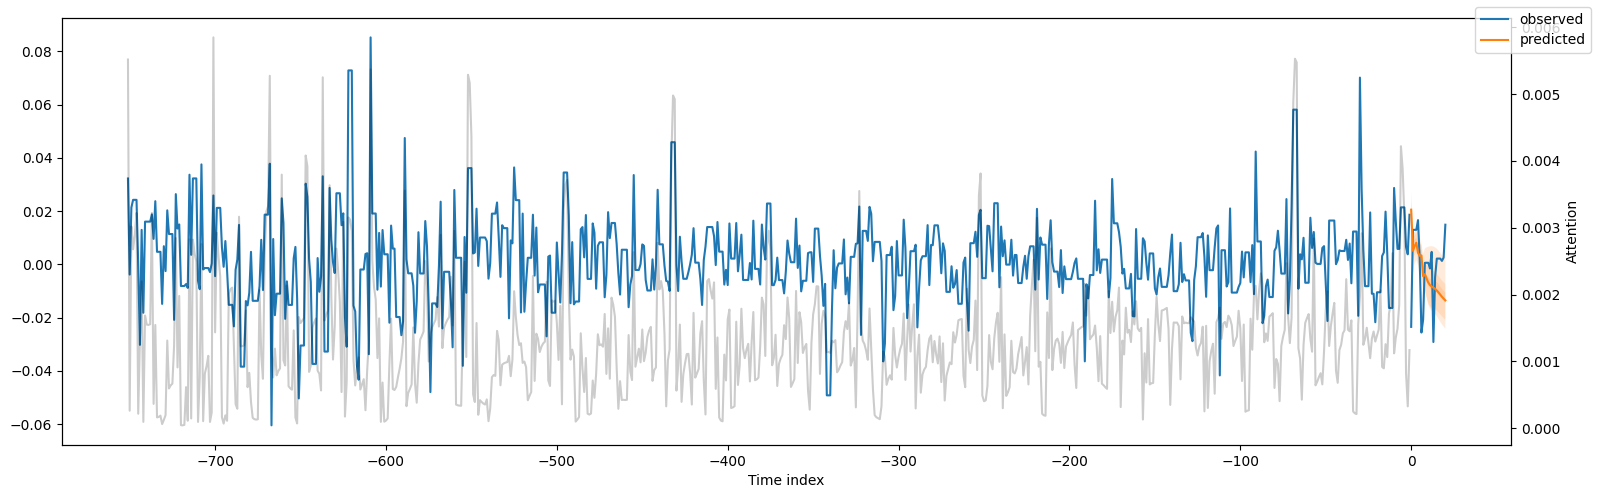

MSFT daily stock return prediction for 2024-07-02 00:00:00 next 21 days


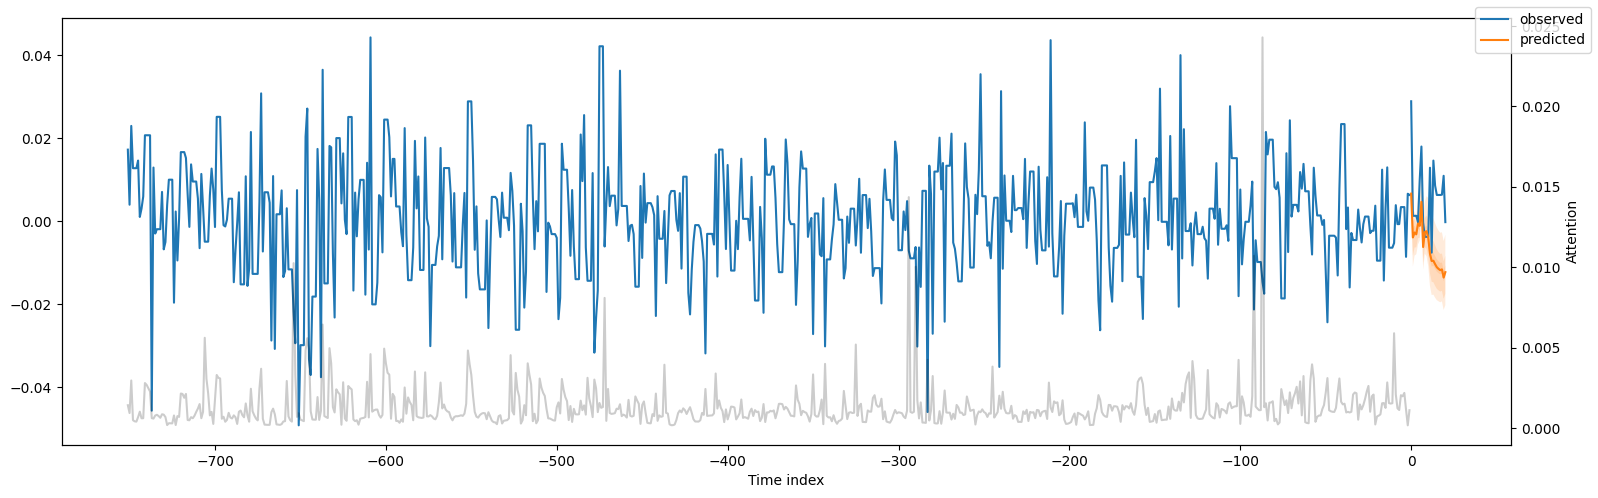

JNJ daily stock return prediction for 2024-07-02 00:00:00 next 21 days


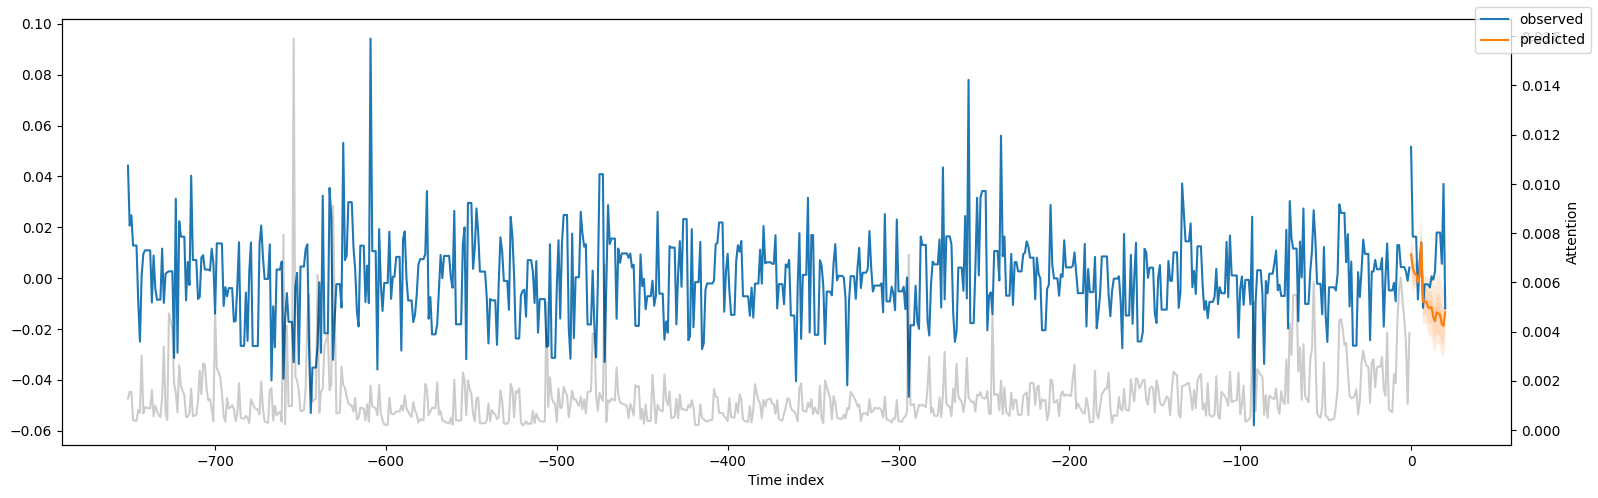

UNH daily stock return prediction for 2024-07-02 00:00:00 next 21 days


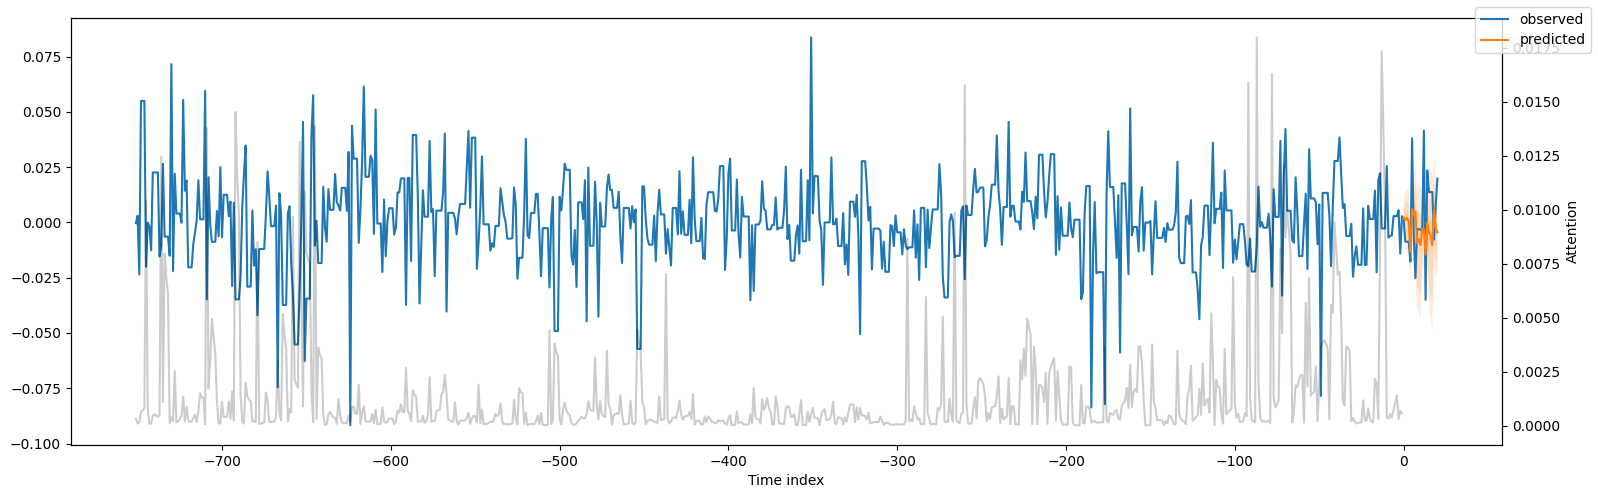

KO daily stock return prediction for 2024-07-02 00:00:00 next 21 days


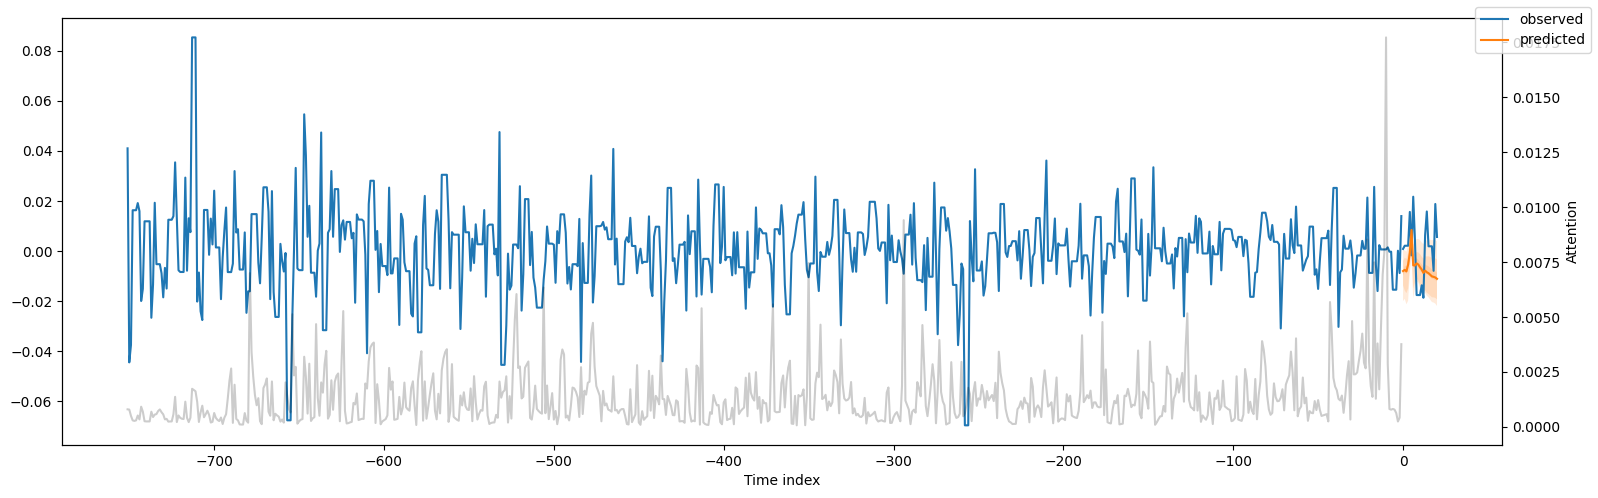

HD daily stock return prediction for 2024-07-02 00:00:00 next 21 days


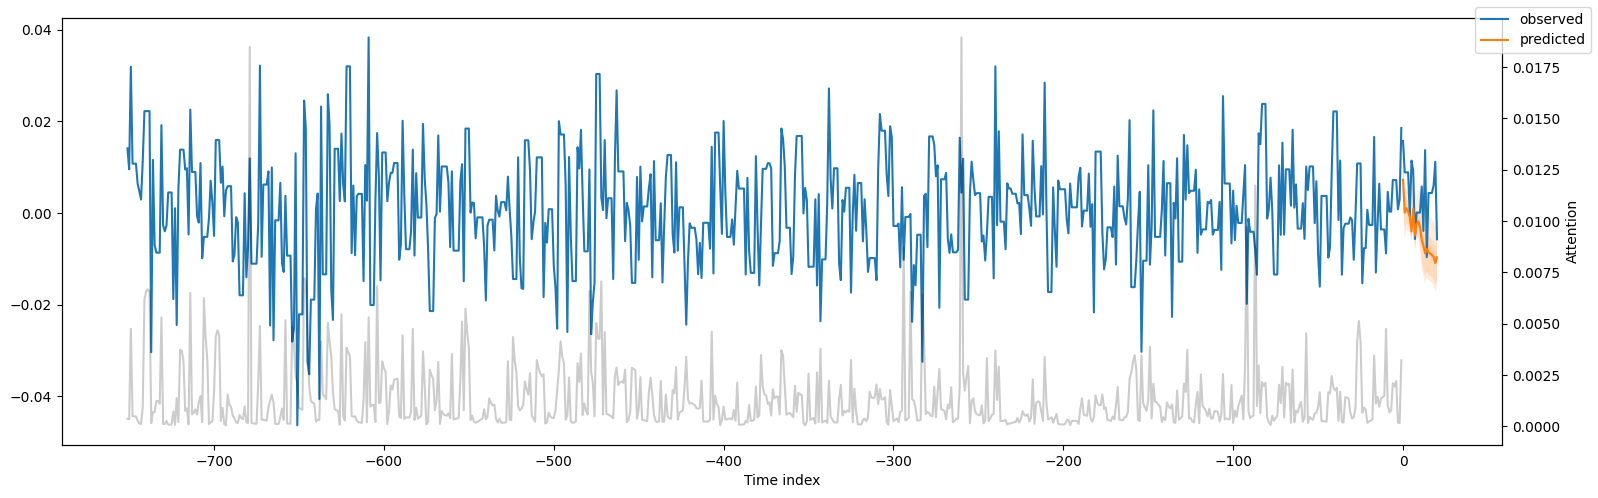

UNP daily stock return prediction for 2024-07-02 00:00:00 next 21 days


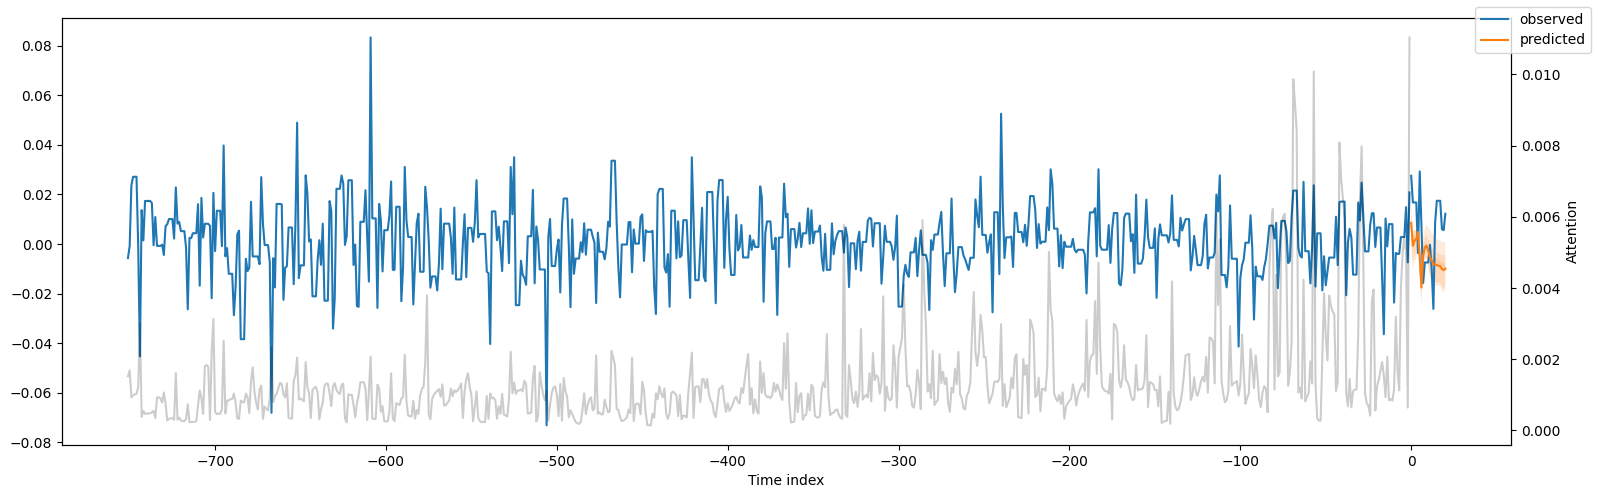

BA daily stock return prediction for 2024-07-02 00:00:00 next 21 days


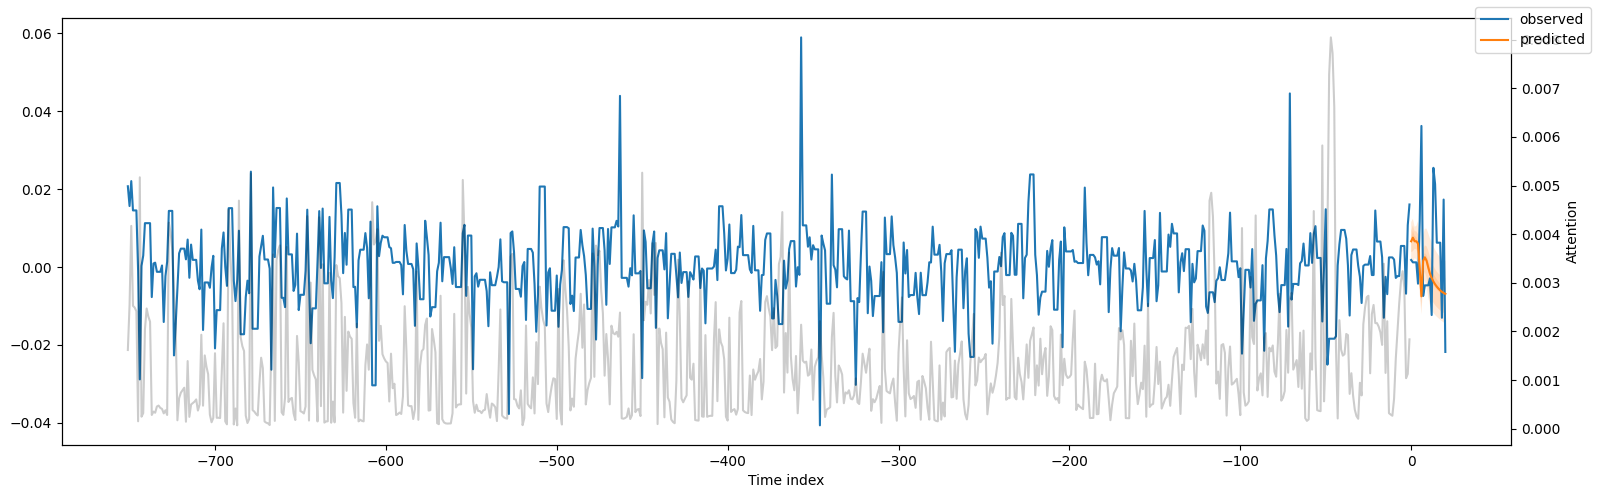

PG daily stock return prediction for 2024-07-02 00:00:00 next 21 days


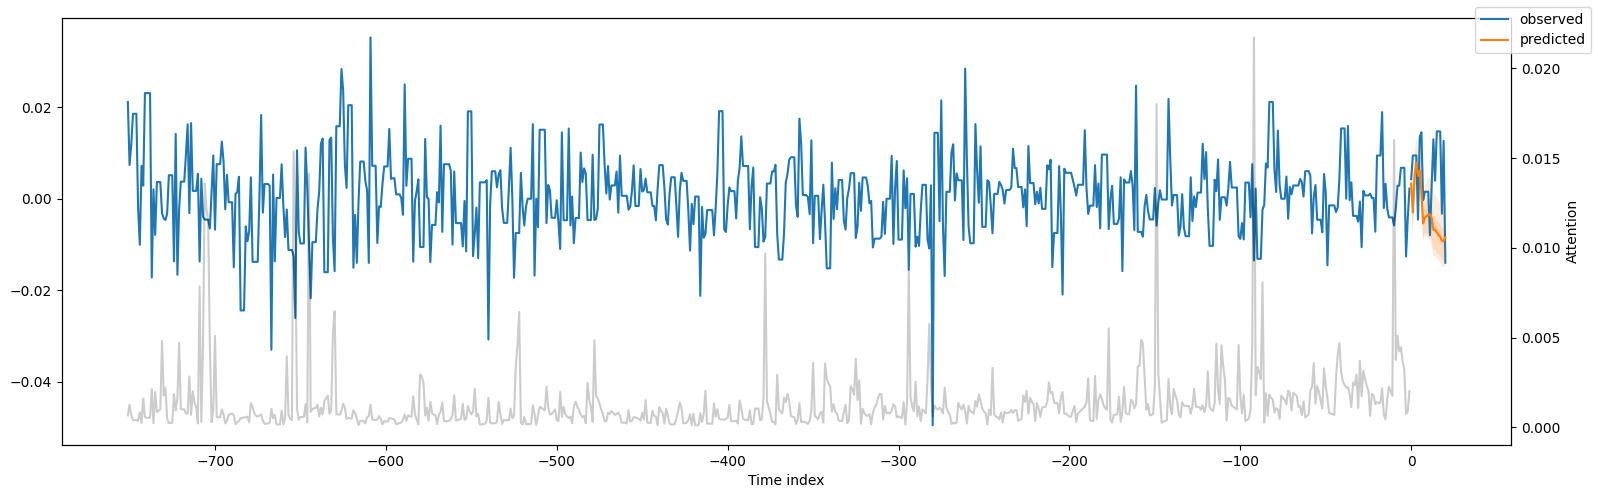

WMT daily stock return prediction for 2024-07-02 00:00:00 next 21 days


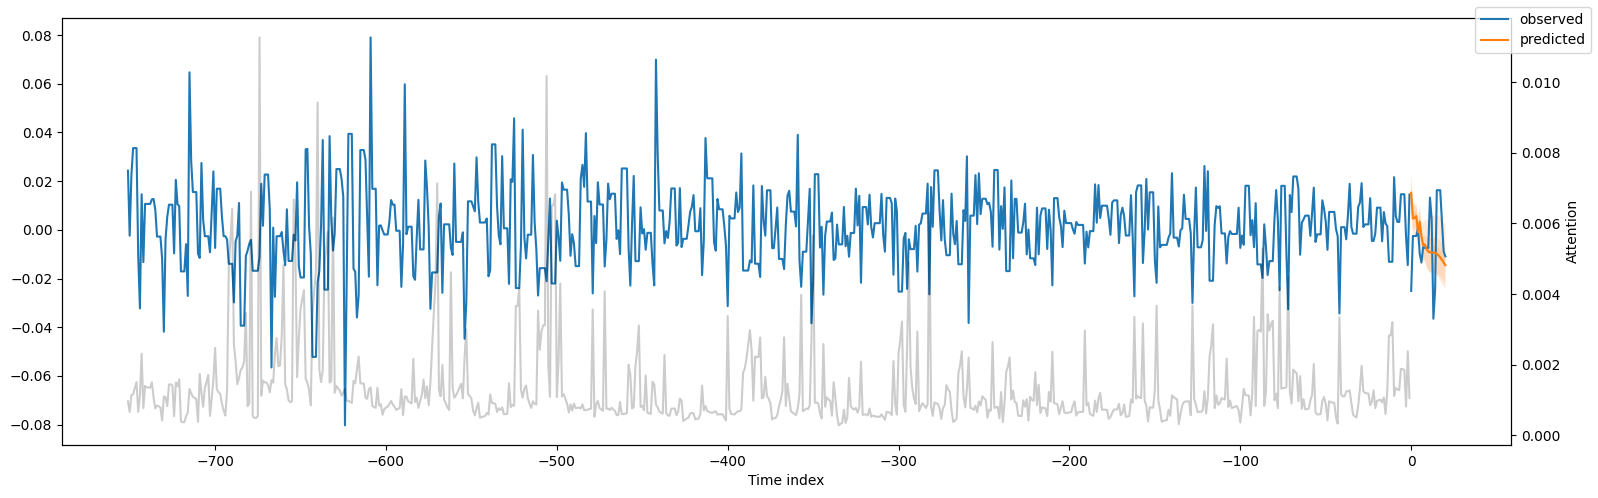

XOM daily stock return prediction for 2024-07-02 00:00:00 next 21 days


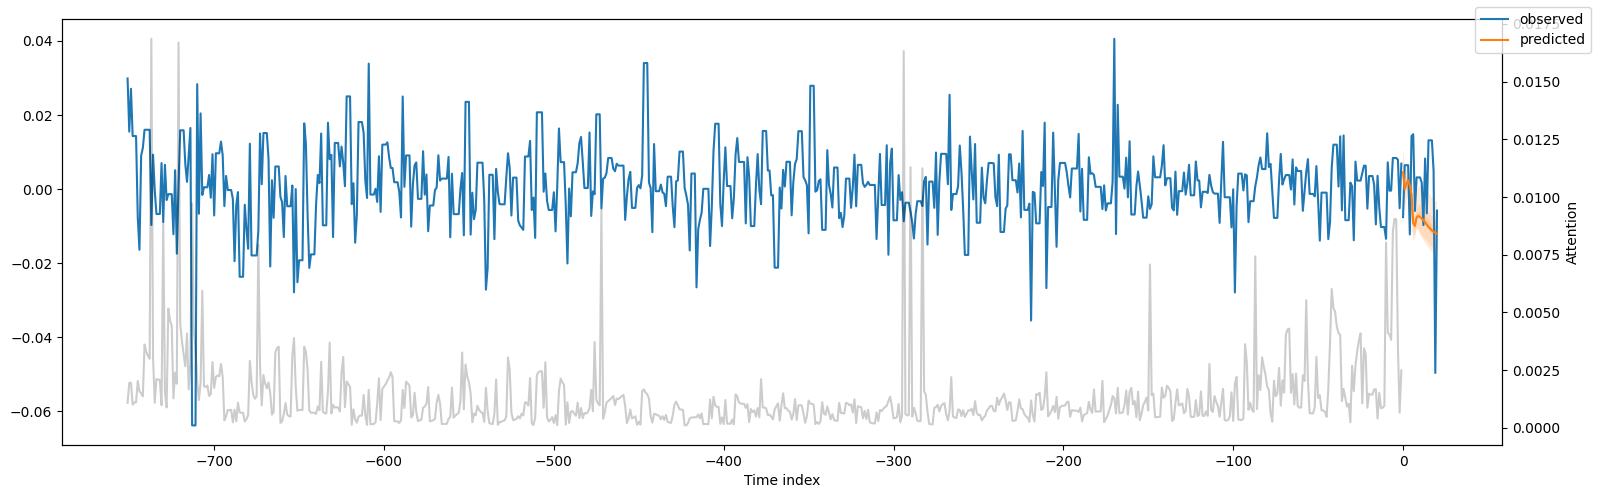

CVX daily stock return prediction for 2024-07-02 00:00:00 next 21 days


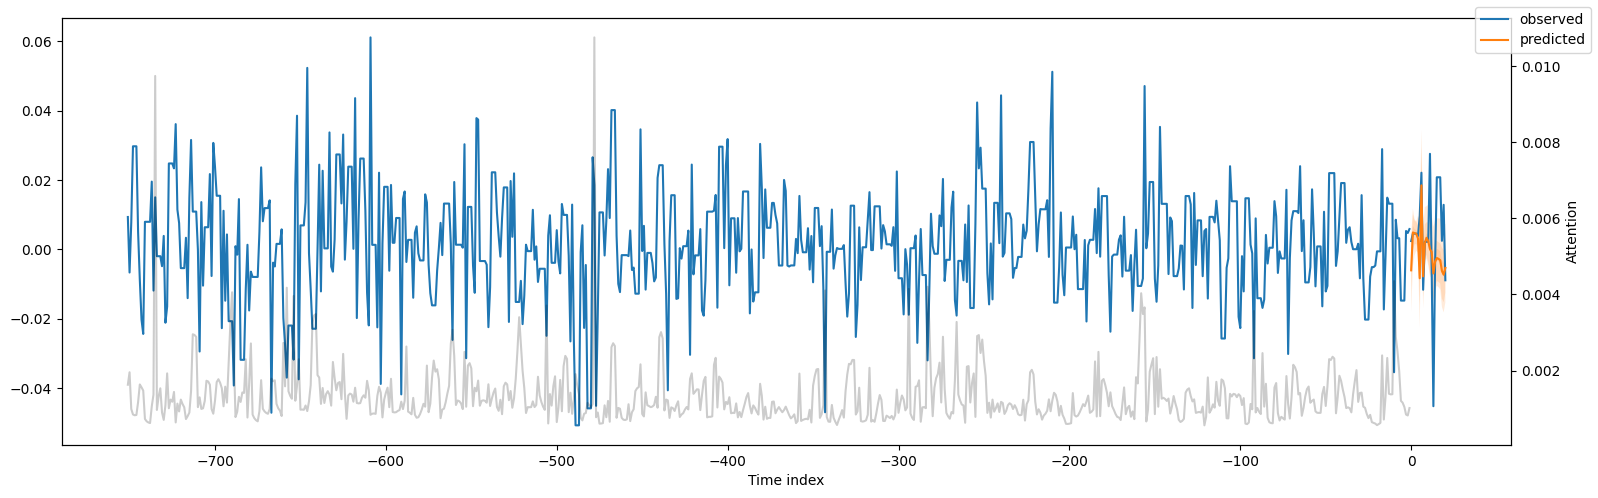

AEP daily stock return prediction for 2024-07-02 00:00:00 next 21 days


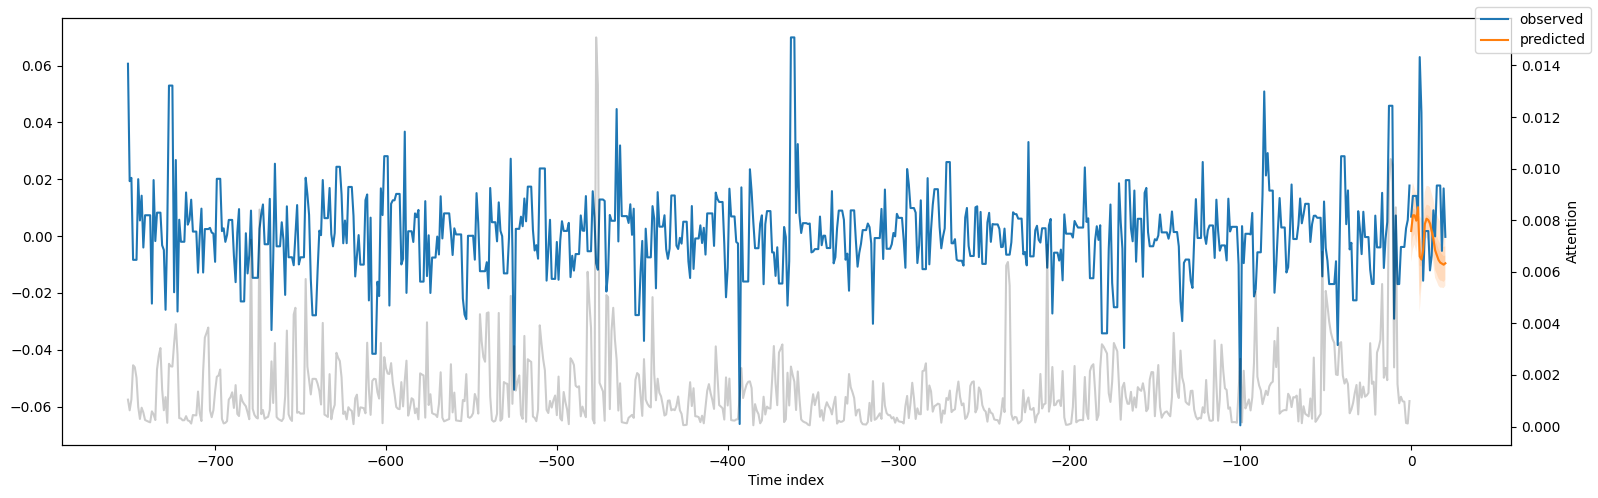

DUK daily stock return prediction for 2024-07-02 00:00:00 next 21 days


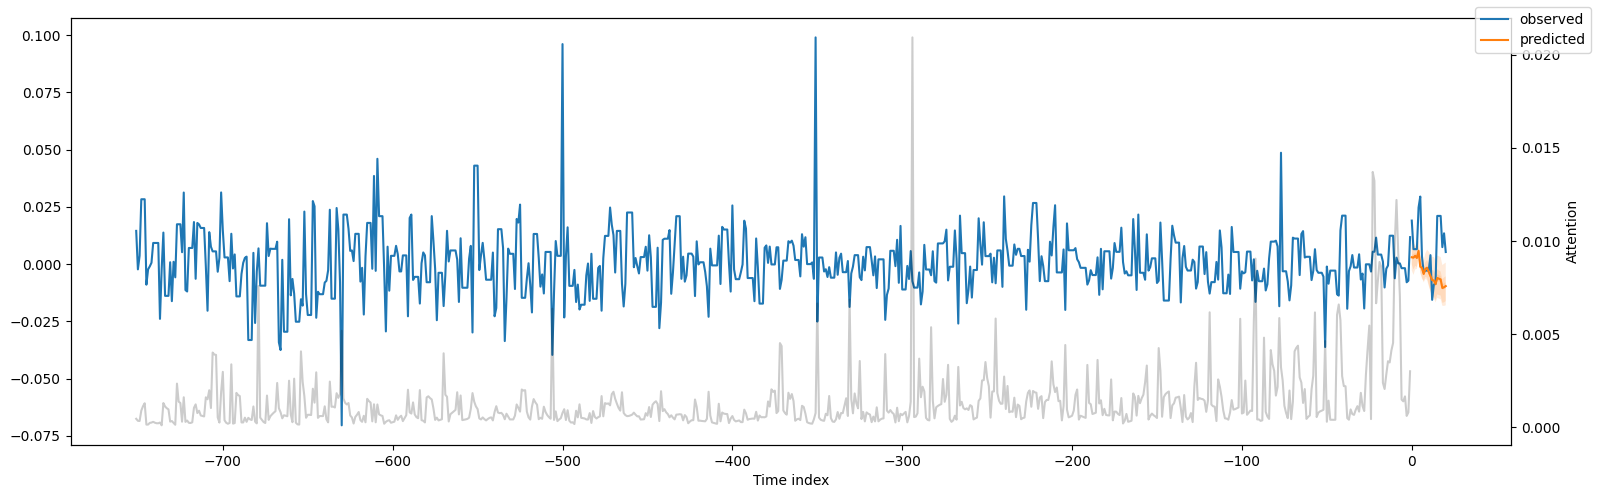

AMT daily stock return prediction for 2024-07-02 00:00:00 next 21 days


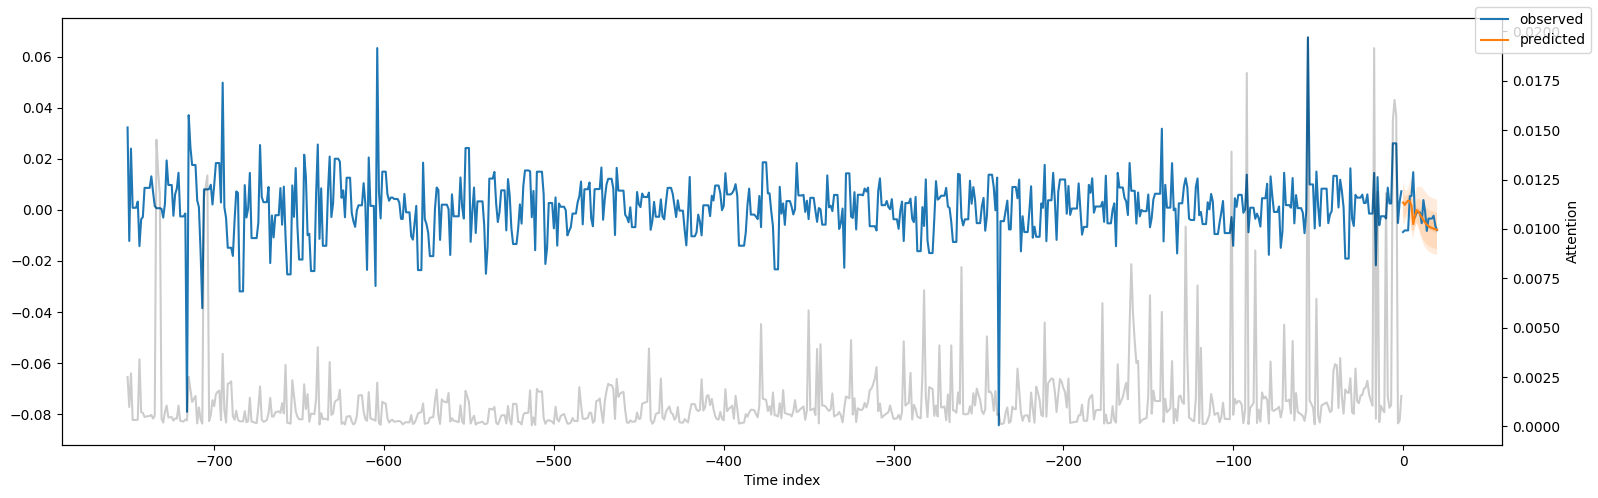

SPG daily stock return prediction for 2024-07-02 00:00:00 next 21 days


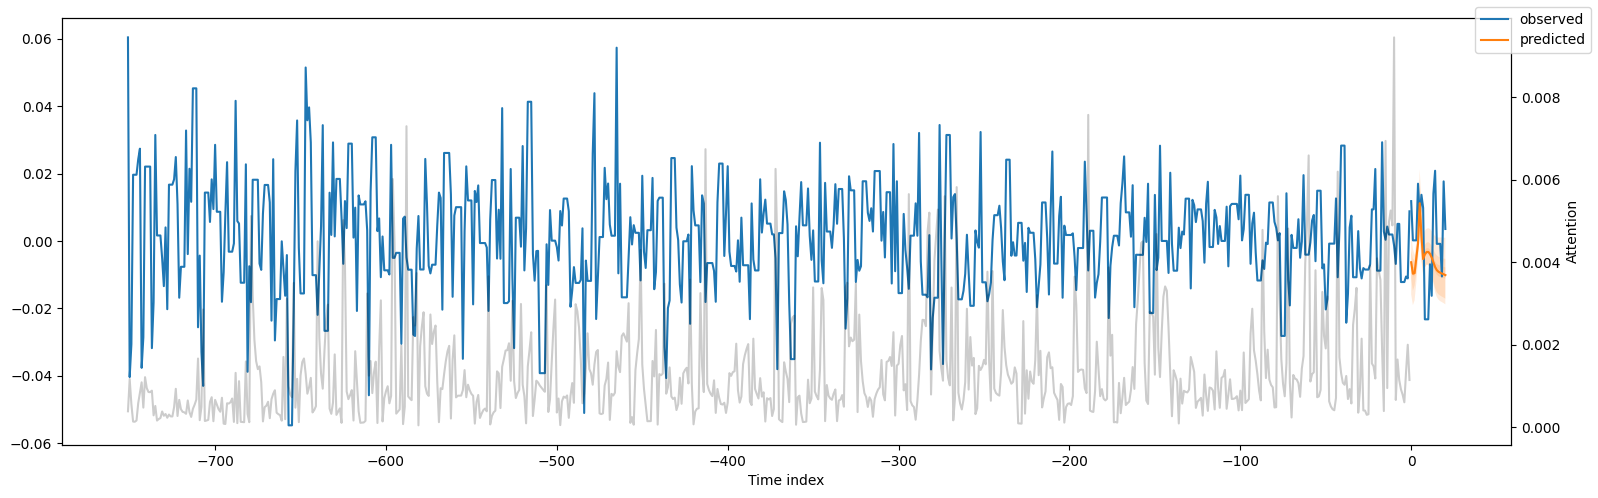

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


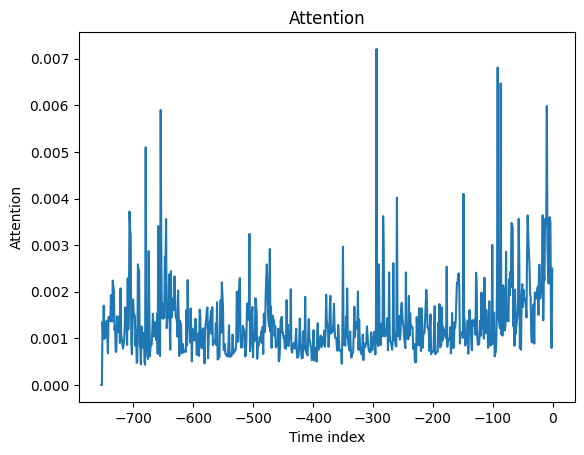

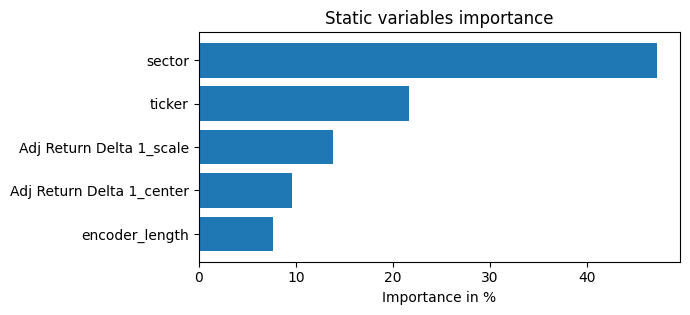

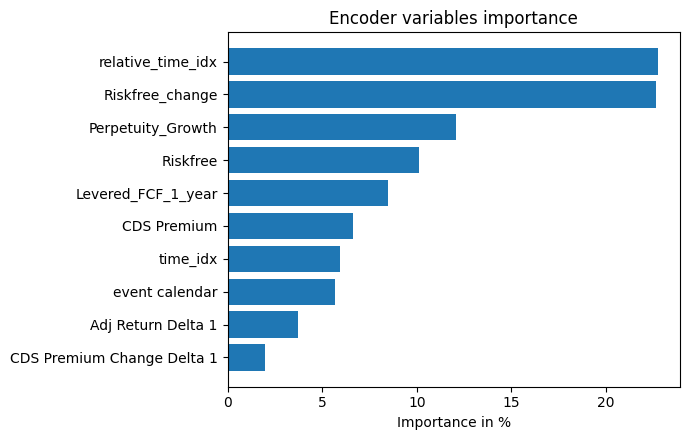

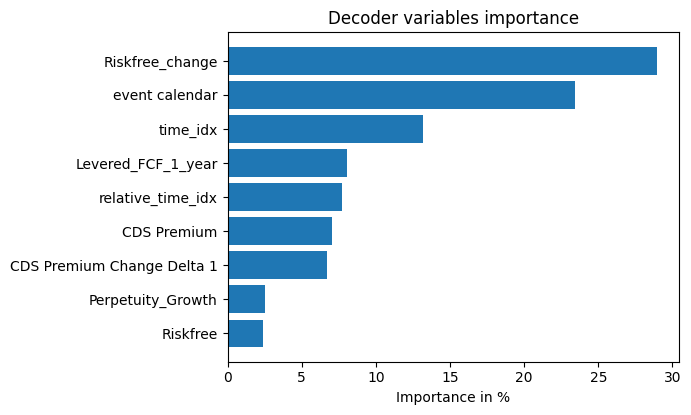

In [ ]:
for i in range(len(time_bounds)-1, len(time_bounds)):

  train_start = time_bounds.iloc[i]['train_start']
  train_end = time_bounds.iloc[i]['train_end']
  predict_start = time_bounds.iloc[i]['predict_start']
  predict_end = time_bounds.iloc[i]['predict_end']

  print(i+1,"/",len(time_bounds), train_start, train_end, predict_end)

  # df_all = build_input(base_path=base_path, data_path=data_path, tickers=tickers, term=term, start=train_start, end=train_end, corr_window=10)
  df_all = build_input(base_path=base_path, data_path=data_path, tickers=tickers, term=term, start=train_start, end=predict_end, corr_window=10)

  encoder_length = len(df_all[(df_all['Date'] >= train_start) & (df_all['Date'] <= train_end)]['Date'].unique())
  predict_length = len(df_all[(df_all['Date'] >= predict_start) & (df_all['Date'] <= predict_end)]['Date'].unique())

  print("encoder_length is ", encoder_length, " and predict_length is ", predict_length)

  training = create_dataset(df_all, encoder_length, predict_length)
  validation = TimeSeriesDataSet.from_dataset(training, df_all, predict=True, stop_randomization=True)

  # create dataloaders for model
  train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=1)
  val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=1)

  # predict_mode (bool) – in val_dataloader
  # if to only iterate over each timeseries once (only the last provided samples).
  # this will take choose for each time series identified by group_ids the last max_prediction_length samples of each time series as prediction samples and everthing previous up to max_encoder_length samples as encoder samples.

  # Naive baseline model for timeseries data.
  actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)]).to("cuda")
  baseline_predictions = Baseline().predict(val_dataloader)
  base_pred_error = (actuals - baseline_predictions).abs().mean().item()
  print(f"Baseline MAE: {base_pred_error:.3f}")


  # configure network and trainer
  pl.seed_everything(100)
  trainer = pl.Trainer(
      accelerator="gpu",
      devices=1,
      gradient_clip_val=0.1,
  )

  tft = TemporalFusionTransformer.from_dataset(
      training,
      learning_rate=0.20,
      hidden_size=64, # number of neurons of each Dense layer of the GRN.
      # Note that since the final layer of the GRN is just a normalization layer, also the output of the GRN has dimension hidden_size
      attention_head_size=4, # number of attention heads. Set to up to 4 for large datasets
      dropout=0.1,  # between 0.1 and 0.3 are good values
      hidden_continuous_size=64,  # set to <= hidden_size
      loss=QuantileLoss([0.01, 0.05, 0.33, 0.5, 0.77, 0.95,0.99]),
      # optimizer="Ranger"
      # reduce_on_plateau_patience=1000, # reduce learning rate if no improvement in validation loss after x epochs
  )
  print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


  # find optimal learning rate
  # from lightning.pytorch.tuner import Tuner
  res = Tuner(trainer).lr_find(
      tft,
      train_dataloaders=train_dataloader,
      val_dataloaders=val_dataloader,
      max_lr=10.0,
      min_lr=1e-6,
  )

  print(f"suggested learning rate: {res.suggestion()}")
  try:
      optimal_learning_rate = res.suggestion()
      fig = res.plot(show=True, suggest=True)
      fig.show()
  except:
      optimal_learning_rate = 0.10
      print("Learning rate finder failed. Setting learning rate to 0.1")

  # configure network and trainer
  early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
  lr_logger = LearningRateMonitor()  # log the learning rate
  logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

  learning_rate = optimal_learning_rate # from above cell output

  trainer = pl.Trainer(
      max_epochs=20,  # set max epoch
      accelerator="gpu",
      devices=1,
      # strategy="ddp_spawn
      enable_model_summary=True,
      gradient_clip_val=0.1,

      # limit_train_batches=50,  # coment in for training, running valiation every 30 batches
      # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs

      callbacks=[lr_logger, early_stop_callback],
      logger=logger,
  )

  tft = TemporalFusionTransformer.from_dataset(
      training,
      learning_rate= learning_rate,
      hidden_size=64,
      attention_head_size=4,
      dropout=0.1,
      hidden_continuous_size=64,
      loss=QuantileLoss([0.01, 0.05, 0.33, 0.5, 0.77, 0.95,0.99]), # qualtiles to predict
      log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
      # optimizer="Ranger",
      reduce_on_plateau_patience=4,
  )
  print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

  # fit network
  trainer.fit(
      tft,
      train_dataloaders=train_dataloader,
      val_dataloaders=val_dataloader,
  )

  # load the best model according to the validation loss
  # (given that we use early stopping, this is not necessarily the last epoch)
  best_model_path = trainer.checkpoint_callback.best_model_path
  print(f"Best model was saved at epoch {best_model_path.split('=')[-1]}")
  print(f"Best model was saved at location {best_model_path}")

  best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

  # !zip  -r model.zip lightning_logs/lightning_logs/version_1/*
  # !zip -r model.zip f"lightning_logs_adj_return/3_year/version_{version_number}/{predict_start.strftime('%Y-%m-%d')}/*"

  # Get predictions on the validation set and calculate the average P50 (quantile median) loss:
  actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to('cuda')
  predictions = best_tft.predict(val_dataloader)

  print(f"Baseline MAE: {base_pred_error:.3f}")
  print(f"{predict_start} period prediction MAE")
  #average p50 loss overall
  print((actuals - predictions).abs().mean().item())
  total_error_sum = (actuals - predictions).abs().mean().item()
  #average p50 loss per time series
  print((actuals - predictions).abs().mean(axis=1))
  total_error_list = (actuals - predictions).abs().mean(axis=1)


  ##Take a look at what the raw_predictions variable contains
  raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

  target_result = pd.DataFrame(raw_predictions.x['decoder_target'].cpu().numpy().T, columns=tickers)

  pred_scenario_low3 = pd.DataFrame(raw_predictions.output['prediction'][:,:, 0].cpu().numpy().T, columns=tickers)
  pred_scenario_low2 = pd.DataFrame(raw_predictions.output['prediction'][:,:, 1].cpu().numpy().T, columns=tickers)
  pred_scenario_low1 = pd.DataFrame(raw_predictions.output['prediction'][:,:, 2].cpu().numpy().T, columns=tickers)
  pred_scenario_mid  = pd.DataFrame(raw_predictions.output['prediction'][:,:, 3].cpu().numpy().T, columns=tickers)
  pred_scenario_high1 = pd.DataFrame(raw_predictions.output['prediction'][:,:, 4].cpu().numpy().T, columns=tickers)
  pred_scenario_high2 = pd.DataFrame(raw_predictions.output['prediction'][:,:, 5].cpu().numpy().T, columns=tickers)
  pred_scenario_high3 = pd.DataFrame(raw_predictions.output['prediction'][:,:, 6].cpu().numpy().T, columns=tickers)

  target_result.to_csv(numeric_path + f"{predict_start.strftime('%Y-%m-%d')}/target.csv")
  pred_scenario_low1.to_csv(numeric_path + f"{predict_start.strftime('%Y-%m-%d')}/prediction_low1.csv")
  pred_scenario_low2.to_csv(numeric_path + f"{predict_start.strftime('%Y-%m-%d')}/prediction_low2.csv")
  pred_scenario_low3.to_csv(numeric_path + f"{predict_start.strftime('%Y-%m-%d')}/prediction_low3.csv")
  pred_scenario_mid.to_csv(numeric_path + f"{predict_start.strftime('%Y-%m-%d')}/prediction_mid.csv")
  pred_scenario_high1.to_csv(numeric_path + f"{predict_start.strftime('%Y-%m-%d')}/prediction_high1.csv")
  pred_scenario_high2.to_csv(numeric_path + f"{predict_start.strftime('%Y-%m-%d')}/prediction_high2.csv")
  pred_scenario_high3.to_csv(numeric_path + f"{predict_start.strftime('%Y-%m-%d')}/prediction_high3.csv")


  # plot predictions on the validation data using the idx argument,
  # this iterates over all time-series in our dataset
  for idx in range(raw_predictions.output.prediction.shape[0]):  # plot all groups of model
      fig, ax = plt.subplots(figsize=(16, 5))

      print(f"{tickers[idx]} daily stock return prediction for {predict_start} next {predict_length} days")
      best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=False,ax=ax)
      # best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=False,ax=ax)

      # plt.title(f"{tickers[idx]} correlation prediction for {train_end} next {predict_length} days")
      plt.savefig(plot_path + predict_start.strftime('%Y-%m-%d') + "/" + f"{predict_start.strftime('%Y-%m-%d')}_{tickers[idx]}_prediction.png")
      plt.show()


  raw_predictions= best_tft.predict(val_dataloader, mode="raw", return_x=True)
  interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
  # best_tft.plot_interpretation(interpretation)

  for key, fig in best_tft.plot_interpretation(interpretation).items():
      fig.savefig(interprete_path  + f"{predict_start.strftime('%Y-%m-%d')}_{key}_interpretion.png")


In [ ]:
import os
os._exit(00)